# Análise e predição de séries temporais para taxas de desemprego dos EUA

Poucas variáveis macroeconômicas são tão importantes como o desemprego. Neste trabalho, iremos fazer uma análise desta variável bem como iremos modelá-la. Usaremos dados das taxas de desemprego (mensais) para três estados dos Estados Unidos: Nova Iorque, Michigan e Iowa - bem como também incorporaremos na nossa análise a taxa de desemprego dos Estados Unidos (mas, esta taxa não será objeto final de análise, mas servirá para termos alguma base ao analisar as outras taxas de desemprego). Escolhemos estes três estados não por acaso: Michigan é um estado com predominância da atividade industrial, Iowa é um estado com predominância da agrícola e Nova Iorque tem predominância de serviços. <br />
Levando isso em conta, nosso projeto será dividido em duas partes:
- 1. Análise de séries temporais
- 2. Modelagem e previsão de séries temporais

## 1. Análise de séries temporais

Nesta parte do projeto, iremos explorar os dados, formular algumas hipóteses e perceber algumas tendências nas taxas de desemprego. Começaremos importando os dados e colocando-os em um dataframe, bem como iremos limpar o que for preciso.

In [1]:
# Importando as bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

Aqui, iremos importar as bases de dados. Estas bases estão disponíveis no site do FRED (https://fred.stlouisfed.org/).

In [2]:
# Importando as bases de dados
ny = pd.read_csv("Downloads\\NYUR.csv")
usa = pd.read_csv("Downloads\\UNRATE.csv")
michigan = pd.read_csv("Downloads\\MIUR.csv")
iowa = pd.read_csv("Downloads\\IAUR.csv")

Vamos dar uma olhada para saber como os dataframes são. Pegaremos, por exemplo, o dataframe "ny", correspondente à série temporal da taxa de desemprego para Nova Iorque:

In [3]:
# Dando uma olhada no dataframe
ny

,DATE,NYUR
0,1976-01-01,10.3
1,1976-02-01,10.3
2,1976-03-01,10.2
3,1976-04-01,10.2
4,1976-05-01,10.1
...,...,...
548,2021-09-01,6.0
549,2021-10-01,5.7
550,2021-11-01,5.4
551,2021-12-01,5.4


Note que o dataframe tem uma coluna de "data". Para fins de conveniência, seria muito melhor se esta coluna fosse o index do dataframe (é muito mais fácil de acessar os valores da série temporal usando suas respectivas datas). Então, faremos isso para todos os dataframes:

In [4]:
# Criando uma lista de dataframes para podermos iterar
dfs = [ny, usa, michigan, iowa]
for i in dfs:
    # Transforma a coluna "DATE" em dados em formato de data e armazena-os em "dates"
    dates = pd.to_datetime(i["DATE"])
    # Descarta a coluna "DATE"
    del i["DATE"]
    # Transforma o index de cada dataframe na coluna "DATE" em formato de data
    i.set_index(dates, inplace = True)

Vamos inspecionar os dataframes para sabermos se temos valores faltantes ou inconsistências que precisamos corrigir.

In [5]:
# Inspecionando os dataframes
for i in [ny, usa, michigan, iowa]:
    i.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 553 entries, 1976-01-01 to 2022-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   NYUR    553 non-null    float64
dtypes: float64(1)
memory usage: 8.6 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 890 entries, 1948-01-01 to 2022-02-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   UNRATE  890 non-null    float64
dtypes: float64(1)
memory usage: 13.9 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 553 entries, 1976-01-01 to 2022-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MIUR    553 non-null    float64
dtypes: float64(1)
memory usage: 8.6 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 553 entries, 1976-01-01 to 2022-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  ----

Como podemos ver, todos os dataframes contêm apenas float64 como o tipo de dado nas colunas (o que é bom!) e nenhuma entrada nula. Daí, podemos prosseguir. <br />
Nosso objetivo agora é criar, por conveniência, um dataframe que tenha todas as séries temporais, sendo cada coluna correspondente a uma delas.

In [6]:
# Concatenando os dataframes
rates = pd.concat([usa, ny, michigan, iowa], axis=1)

In [7]:
# Checando o novo dataframe
rates

,UNRATE,NYUR,MIUR,IAUR
DATE,,,,
1948-01-01,3.4,NaN,NaN,NaN
1948-02-01,3.8,NaN,NaN,NaN
1948-03-01,4.0,NaN,NaN,NaN
1948-04-01,3.9,NaN,NaN,NaN
1948-05-01,3.5,NaN,NaN,NaN
...,...,...,...,...
2021-10-01,4.6,5.7,5.4,4.0
2021-11-01,4.2,5.4,5.2,3.9
2021-12-01,3.9,5.4,5.1,3.9


Perceba que, pelo fato de termos observações para a taxa de desemprego dos Estados Unidos em períodos nos quais não temos os valores da taxa de desemprego para os estados, o nosso dataframe ficou com vários valores faltantes. Como a taxa de desemprego dos EUA não vai ser objeto último de análise, podemos descartar as linhas que só têm observações para a taxa de desemprego dos EUA. 

In [8]:
rates.dropna(inplace = True)
rates

,UNRATE,NYUR,MIUR,IAUR
DATE,,,,
1976-01-01,7.9,10.3,9.9,4.3
1976-02-01,7.7,10.3,9.9,4.3
1976-03-01,7.6,10.2,9.9,4.3
1976-04-01,7.7,10.2,9.8,4.2
1976-05-01,7.4,10.1,9.6,4.1
...,...,...,...,...
2021-09-01,4.7,6.0,5.7,4.1
2021-10-01,4.6,5.7,5.4,4.0
2021-11-01,4.2,5.4,5.2,3.9


In [9]:
# Vendo que não há mais nenhum valor faltante
rates.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 553 entries, 1976-01-01 to 2022-01-01
Freq: MS
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   UNRATE  553 non-null    float64
 1   NYUR    553 non-null    float64
 2   MIUR    553 non-null    float64
 3   IAUR    553 non-null    float64
dtypes: float64(4)
memory usage: 21.6 KB


Convenientemente, vamos renomear as colunas:

In [10]:
rates.rename(columns = {"UNRATE":"EUA", "NYUR":"Nova Iorque", "MIUR":"Michigan", "IAUR": "Iowa"}, inplace = True)

Agora que já organizamos os dados de forma conveniente, vamos começar a nossa análise. Vamos começar plotando um gráfico com todas as taxas de desemprego durante todo o período que temos disponível.

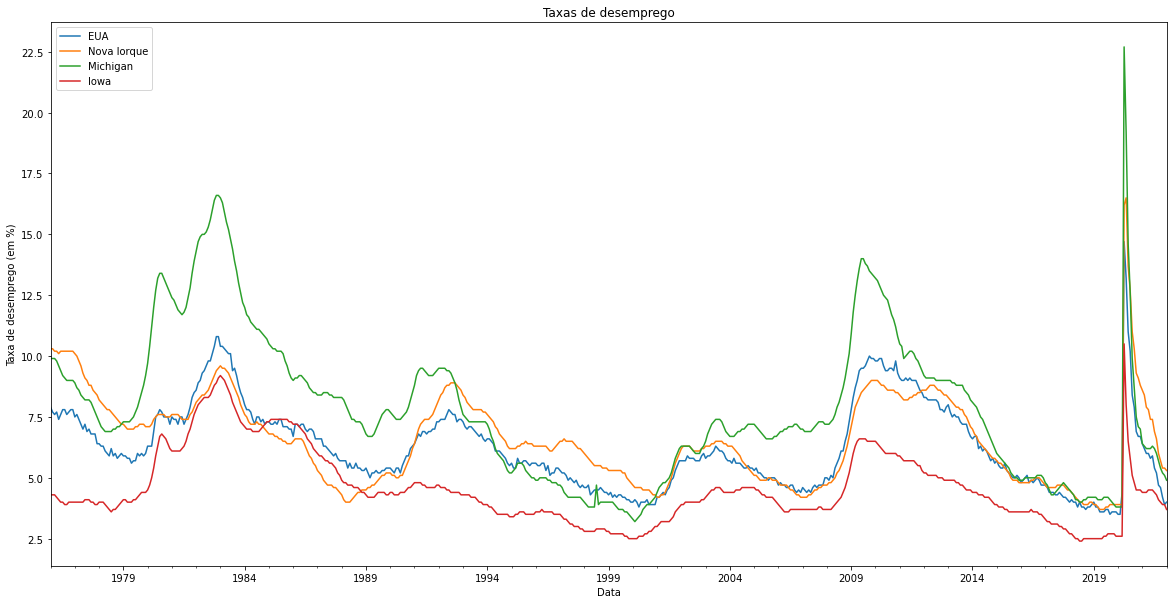

In [11]:
# Criando o plot e ajustando o tamanho
rates.plot(figsize = (20, 10))
# Colocando título e legendas
plt.title("Taxas de desemprego")
plt.xlabel("Data")
plt.ylabel("Taxa de desemprego (em %)")
# Mostrando o plot
plt.show()

Algumas conclusões podem ser tiradas deste gráfico. Uma delas é a de que as taxas de desemprego geralmente caminham juntas, isto é, é raro que apenas uma taxa aumente o diminua significativamente sem que o mesmo ocorra com as outras. Além disso, temos alguns momentos de pico no gráfico. Temos três bem expressivos: um no começo dos anos 80, outro em 2008-2009 (crise de 2008) e outro em 2020 (pandemia de covid-19). Além disso, podemos perceber que: Michigan é um estado que, no geral, tem taxas de desemprego mais alta que outros estados; as taxas de desemprego de Nova Iorque e dos EUA parecem "andar juntas"; e Iowa parece ter uma taxa de desemprego, no geral, mais baixa que os outros estados. <br />
Agora, vamos olhar mais especificamente para um período que corresponde à crise de 2008. Como colocamos o index do nosso dataframe como sendo as datas, é muito fácil acessar um dado período de interesse.

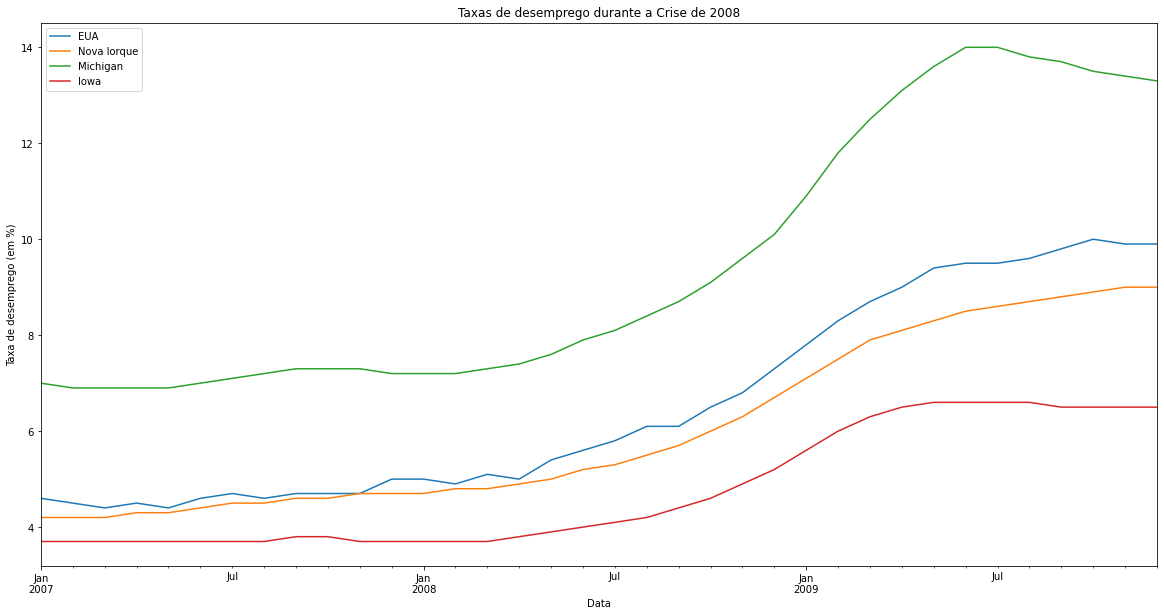

In [12]:
# Criando o plot selecionando o período do começo de 2007 ao fim de 2009 e ajustando o tamanho
rates["2007-01-01":"2009-12-01"].plot(figsize = (20,10))
# Colocando título e legendas no plot
plt.title("Taxas de desemprego durante a Crise de 2008")
plt.xlabel("Data")
plt.ylabel("Taxa de desemprego (em %)")
# Mostrando o plot
plt.show()

Note o seguinte: as quatro taxas seguiram uma tendência ascendente no período que compreende o começo de 2008 e meados para fim de 2009. Contudo, nem todos os estados sofreram choques iguais. Michigan, por exemplo, teve uma ascensão na taxa de desemprego muito mais acentuada do que os outros estados. Iowa, por sua vez, não chegou nem a ter 2 pontos percentuais de aumento na sua taxa de desemprego. Nova Iorque ficou num "meio termo", isto é, o choque foi moderado - como já havíamos observado, Nova Iorque performou parecidamente com o próprio país durante a crise de 2008, apesar de ter seguido uma trajetória substancialmente diferente após o começo de 2009, isto é, ficou com taxas de desemprego mais baixas. <br />
Agora, vamos replicar este método para analisar as taxas de desemprego durante a pandemia de covid-19:

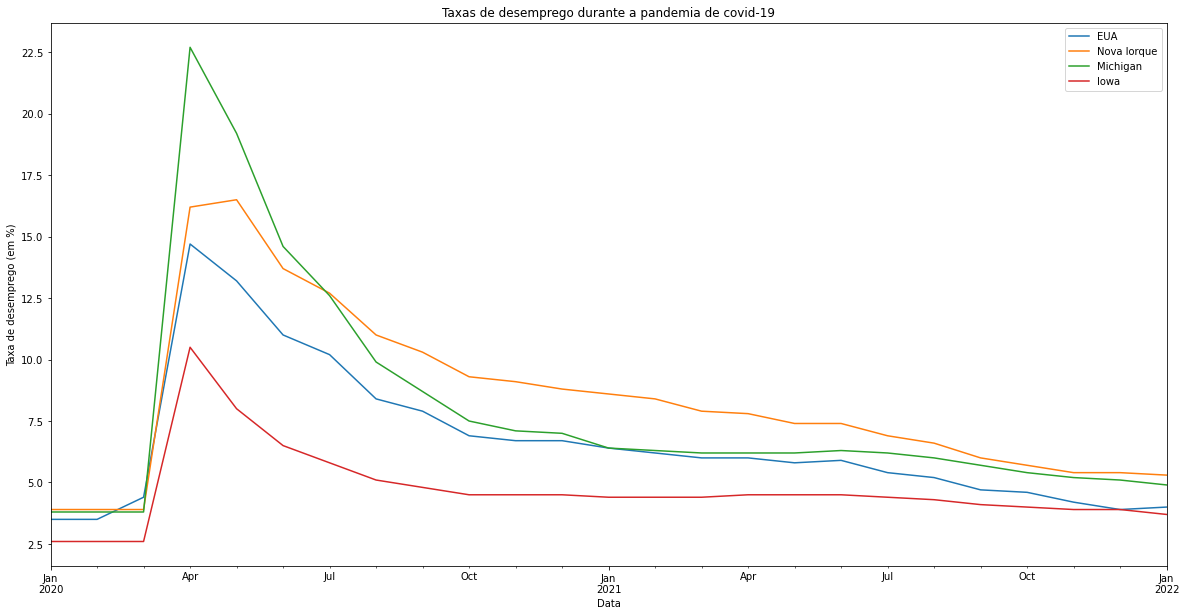

In [13]:
# Criando o plot selecionando o período do começo de 2007 ao começo de 2022
rates["2020-01-01":"2022-01-01"].plot(figsize = (20,10))
# Colocando título e legendas no plot
plt.title("Taxas de desemprego durante a pandemia de covid-19")
plt.xlabel("Data")
plt.ylabel("Taxa de desemprego (em %)")
# Mostrando o plot
plt.show()

Aqui, podemos ver coisas muito interessantes: diferentemente da crise de 2008, onde as taxas de desemprego subiram de uma forma mais "gradativa", na pandemia de covid-19, todas as taxas de desemprego tiveram um pico em abril de 2020. De fato, em abril de 2020, foi quando muitos estados declararam quarentena - causando ondas de demissão em massa. Há mais algumas coisas a serem observadas: Michigan foi, novamente, o estado que mais sofreu com isso. A explicação é clara: como há uma predominância do setor industrial em Michigan, não havia como continuar o trabalho sem a presença física dos trabalhadores - o que foi impossibilitado pela quarentena. Por outro lado, Iowa, um estado com predominância do setor agrícola, não sofreu tanto pois boa parte do seu setor produtivo é mecanizado. Já Nova Iorque, um estado com predominância do setor de serviços, sofreu de uma forma mediana em relação aos outros dois: pois, apesar de existirem atividades que dependiam do trabalho presencial, alguma parte do seu setor produtivo pôde transicionar bem para o trabalho remoto. <br />
Agora que já analisamos dois períodos distintos (vamos voltar a olhá-los conforme avançarmos no nosso projeto), podemos tentar ver mais alguns aspectos gerais dos dados. 

Como já foi dito, a taxa de desemprego dos EUA serve como uma base para nossa análise. Podemos avaliar (podemos, não quer dizer que é a melhor forma de se avaliar) se a taxa de desemprego de um estado está alta ou baixa conforme sua posição relativa em relação à taxa do próprio país. Sabendo disso, vamos sumarizar, em um gráfico, a posição relativa dos estados em relação aos EUA. Para isso, a nossa estratégia será plotar a diferença das taxas em relação à dos EUA, então se um estado estiver - no gráfico - com uma taxa abaixo de 0, significa que sua taxa de desemprego naquele período foi menor do que a dos EUA no mesmo período. Sendo assim, de cada coluna iremos subtrair a coluna correspondente à série temporal de desemprego dos EUA (iremos subtrair também na própria coluna dos EUA, já que dará-nos uma linha horizontal no 0 e isso nos ajudará na visualização).

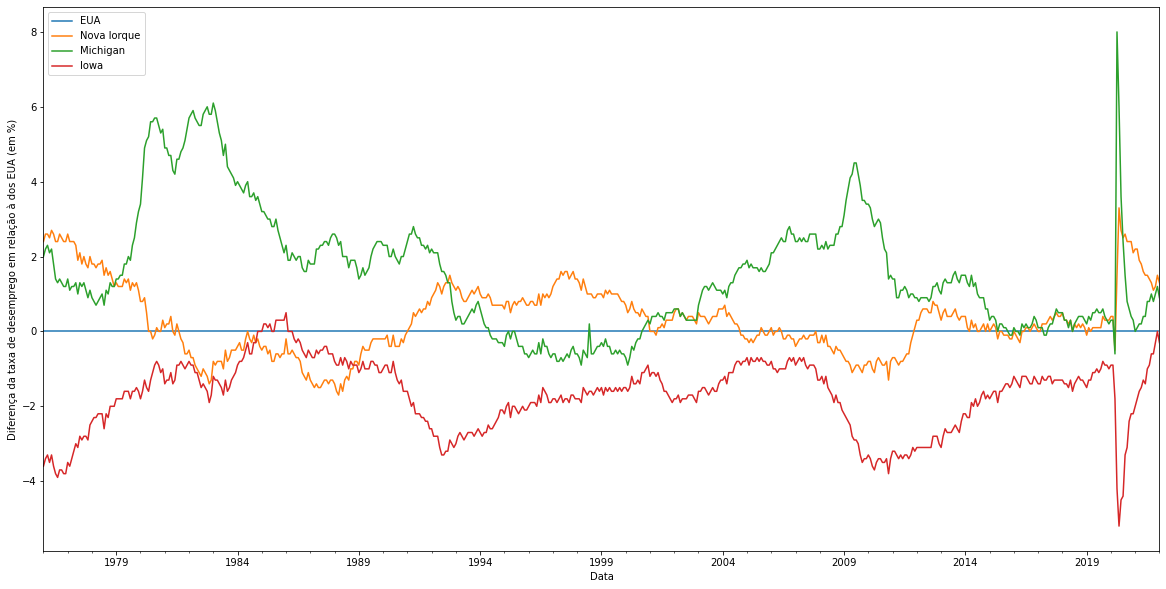

In [14]:
# Subtraindo de cada coluna a coluna das taxas de desemprego para os EUA e criando o plot
rates.sub(rates["EUA"], axis = 0).plot(figsize = (20,10))
# Adicionando legendas ao plot
plt.xlabel("Data")
plt.ylabel("Diferença da taxa de desemprego em relação à dos EUA (em %)")
# Mostrando o plot
plt.show()

Para ver como um estado performou em termos de taxa de desemprego em relação aos EUA, basta ver sua posição relativa em relação à reta azul horizontal (se estiver acima, o desemprego foi maior no período, e vice-versa). Note como é fácil perceber algumas tendências já observadas nos dados: na maior parte do tempo, Michigan teve taxas de desemprego maiores do que as nacionais, enquanto que Iowa teve a tendência contrária - Nova Iorque, por sua vez, mantém-se numa "faixa" de 2 pontos percentuais em relação à taxa de desemprego dos EUA (i.e., no plot, veja que raramente a linha amarela sobe para mais de 2 pontos percentuais ou desce para menos de dois pontos percentuais). Caso nossa intuição obtida com visualização de dados esteja certa, ela deve ser confirmada usando recursos estatísticos. Aqui, usaremos o recurso mais simples (iremos apenas calcular as médias e compará-las).

In [15]:
# Calculando as médias de todas as taxas de desemprego
for i in rates.columns:
    print(f"A taxa de desemprego média de/os {i} é {rates[i].mean()}")

A taxa de desemprego média de/os EUA é 6.258770343580468
A taxa de desemprego média de/os Nova Iorque é 6.551537070524419
A taxa de desemprego média de/os Michigan é 7.819891500904154
A taxa de desemprego média de/os Iowa é 4.562386980108494


Nossa intuição estava certa. De fato, a taxa de desemprego média dos EUA é relativamente próxima da de Nova Iorque, enquanto que ela é consideravelmente maior do que a de Iowa e - também consideravelmente - menor do que a de Michigan. <br />
Antes que avancemos mais na nossa análise, podemos estudar as taxas de desemprego olhando para suas taxas de crescimento. Isto é útil pois um crescimento percentual "grande" da taxa de desemprego indica um choque no mercado de trabalho, enquanto que um crescimento "pequeno" indica um período de normalidade no mercado de trabalho. Os termos estão entre aspas pois, de fato, é muito difícil precisar o que é "pequeno" ou "grande" a priori. Contudo, quando olhamos para os dados, podemos perceber o que é pequeno ou grande. Considere o seguinte plot, onde tudo ficará mais claro:

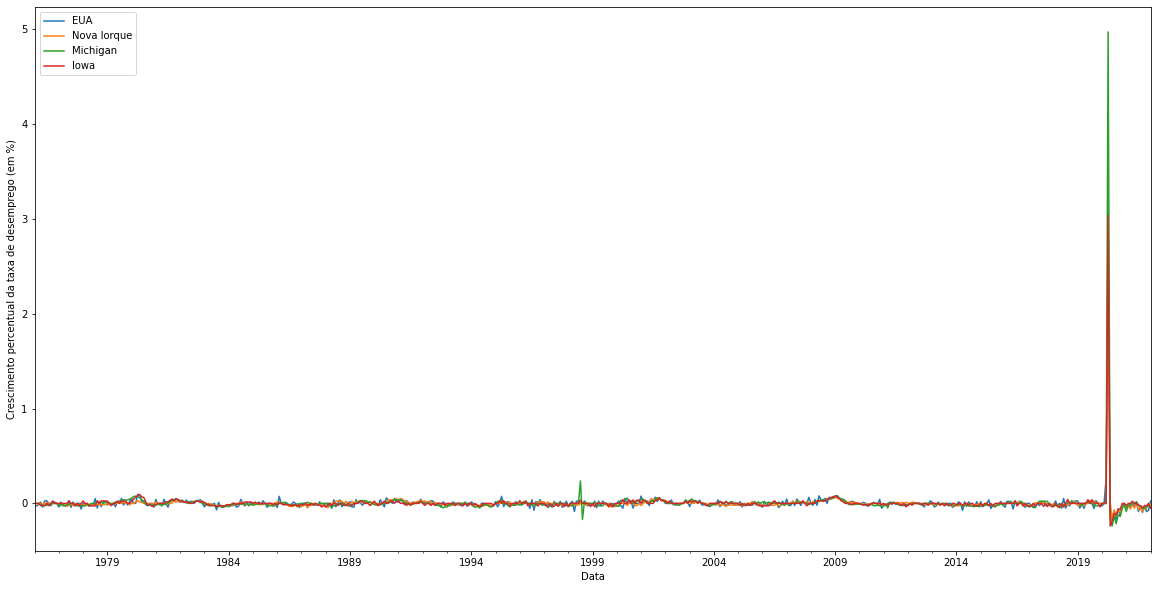

In [16]:
# Calculando os crescimentos percentuais das taxas de desemprego e criando o plot
rates.pct_change().plot(figsize = (20,10))
# Adicionando legendas para o plot
plt.xlabel("Data")
plt.ylabel("Crescimento percentual da taxa de desemprego (em %)")
# Mostrando o plot
plt.show()

Agora, olhando para o gráfico, podemos entender bem o que significa um crescimento "pequeno" ou "grande" da taxa de desemprego. Na maior parte do tempo, as taxas de desemprego variam (de um mês para outro) a uma razão muito próxima de 0. Contudo, em momentos de choque no mercado de trabalho, esta razão pode ser "grande" (olhe para o período de 2020 no gráfico). Este gráfico dá-nos algumas informações interessantes: a primeira coisa que nos salta aos olhos é a observação de que, no mercado de trabalho americano, no período de 1976 a 2022, não houve nenhum choque no mercado de trabalho tão grande quanto o que ocorreu no começo de 2020 (isto é, no começo da pandemia de Covid-19). Note que temos algumas oscilações que fogem à tendência geral do crescimento percentual da taxa de desemprego (olhe, no gráfico, o começo da década de 80, fim do século XX e período da crise de 2008), mas estas oscilações ainda assim não se distanciam muito do crescimento percentual próximo de 0 - já na pandemia de covid-19, temos um crescimento percentual que chega a incríveis 400% (e 500% para Michigan) de um mês para outro. Veja como o aspecto do gráfico mudará quando excluirmos períodos após março de 2020:

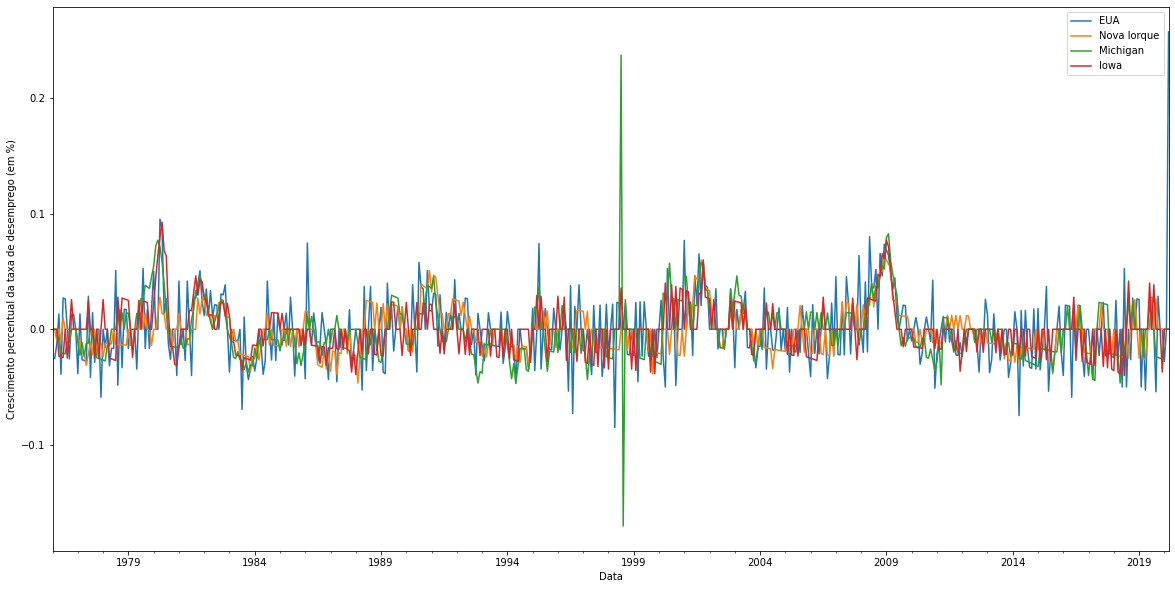

In [17]:
# Calculando os crescimentos percentuais das taxas de desemprego para datas anteriores a abril de 2020 e criando o plot
rates[:"03-2020"].pct_change().plot(figsize = (20,10))
# Adicionando legendas para o plot
plt.xlabel("Data")
plt.ylabel("Crescimento percentual da taxa de desemprego (em %)")
# Mostrando o plot
plt.show()

Antes da pandemia de covid-19, o maior crescimento percentual da taxa de desemprego foi algo próximo de 20% - muito distante dos valores vistos em abril de 2020. Daí, vemos como a pandemia de covid-19 impactou muito mais o mercado de trabalho do que alguns outros eventos adversos como a Crise de 2008, por exemplo.

Como vimos, podemos extrair várias informações quando tomamos diferentes métricas. Vamos criar uma função que, dado um período, retorna-nos várias métricas e gráficos para este período. Isto é, vamos criar uma função que funciona como um "report" ou relatório. A função receberá: um dataframe (um dataframe de séries temporais), uma data de início e uma data de fim; e retornar-nos-á o gráfico de evolução dos valores no tempo, o gráfico do crescimento percentual dos valores no tempo, a média dos valores para cada série e os valores máximos e mínimos para cada série.

In [18]:
def report(df = rates, data_inicio = rates.index[0], data_fim = rates.index[-1]):
    """Função que funciona como um relatório. Seu primeiro argumento "df" serve para especificarmos o dataframe 
    (por default, será o dataframe "rates" com o qual estamos trabalhando). Seus últimos dois argumentos são "data_inicio" e 
    "data_fim" servem para especificarmos o período que queremos analisar, por default, o período será simplesmente aquele
    entre as datas de início e fim do nosso dataframe 'rates'"""
    # Plota a evolução das taxas de desemprego no período especificado com os devidos título e legendas
    df[data_inicio:data_fim].plot()
    plt.xlabel("Data")
    plt.ylabel("Taxas de desemprego (em %)")
    plt.title("Taxas de desemprego")
    plt.show()
    # Plota o crescimento percentual das taxas no período especificado com os devidos título e legendas
    df[data_inicio:data_fim].pct_change().plot()
    plt.xlabel("Data")
    plt.ylabel("Crescimento percentual da taxa de desemprego (em %)")
    plt.title("Crescimento percentual da taxa de desemprego")
    plt.show()
    # Calcula e mostra-nos as taxas de desemprego médias para o período especificado
    for i in df.columns:
        print(f"A taxa de desemprego média no período de {str(data_inicio)[0:10]} a {str(data_fim)[0:10]} em/nos {i} foi de {round(rates[data_inicio:data_fim][i].mean(),2)}")
    print("===============================================================================================================================")
    # Calcula e mostra-nos as taxas de desemprego máximas e mínimas e diz-nos as amplitudes (diferença entre máximo e mínimo) para o período especificado
    for i in df.columns:
        print(f"A taxa de desemprego máxima no período de {str(data_inicio)[0:10]} a {str(data_fim)[0:10]} em/nos {i} foi de {round(rates[data_inicio:data_fim][i].max(),2)}, enquanto a mínima foi de {round(rates[data_inicio:data_fim][i].min(),2)}. A diferença entre os dois valores é de {round(rates[data_inicio:data_fim][i].max() - rates[data_inicio:data_fim][i].min(),2)}")

Vamos mostrar como a função funciona apenas chamando-a - ou seja - chamando-a com os argumentos default, que podem ser omitidos.

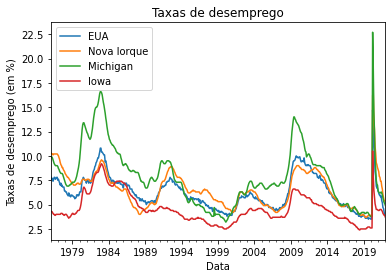

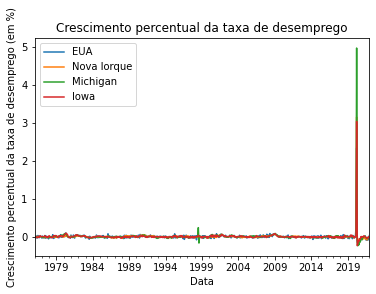

A taxa de desemprego média no período de 1976-01-01 a 2022-01-01 em/nos EUA foi de 6.26
A taxa de desemprego média no período de 1976-01-01 a 2022-01-01 em/nos Nova Iorque foi de 6.55
A taxa de desemprego média no período de 1976-01-01 a 2022-01-01 em/nos Michigan foi de 7.82
A taxa de desemprego média no período de 1976-01-01 a 2022-01-01 em/nos Iowa foi de 4.56
A taxa de desemprego máxima no período de 1976-01-01 a 2022-01-01 em/nos EUA foi de 14.7, enquanto a mínima foi de 3.5. A diferença entre os dois valores é de 11.2
A taxa de desemprego máxima no período de 1976-01-01 a 2022-01-01 em/nos Nova Iorque foi de 16.5, enquanto a mínima foi de 3.7. A diferença entre os dois valores é de 12.8
A taxa de desemprego máxima no período de 1976-01-01 a 2022-01-01 em/nos Michigan foi de 22.7, enquanto a mínima foi de 3.2. A diferença entre os dois valores é de 19.5
A taxa de desemprego máxima no período de 1976-01-01 a 2022-01-01 em/nos Iowa foi de 10.5, enquanto a mínima foi de 2.4. A difere

In [19]:
report()

Agora que já vimos como ela funciona, vamos chamá-la para alguns períodos especiais. O primeiro dele será aquele em que nós vemos um pico relativamente anormal no gráfico do crescimento percentual das taxas de desemprego: isto é, o período do fim do século XX. 

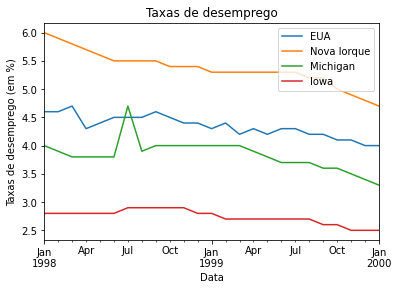

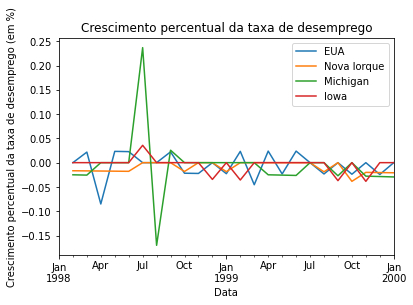

A taxa de desemprego média no período de 1998-01 a 2000-01 em/nos EUA foi de 4.34
A taxa de desemprego média no período de 1998-01 a 2000-01 em/nos Nova Iorque foi de 5.36
A taxa de desemprego média no período de 1998-01 a 2000-01 em/nos Michigan foi de 3.84
A taxa de desemprego média no período de 1998-01 a 2000-01 em/nos Iowa foi de 2.74
A taxa de desemprego máxima no período de 1998-01 a 2000-01 em/nos EUA foi de 4.7, enquanto a mínima foi de 4.0. A diferença entre os dois valores é de 0.7
A taxa de desemprego máxima no período de 1998-01 a 2000-01 em/nos Nova Iorque foi de 6.0, enquanto a mínima foi de 4.7. A diferença entre os dois valores é de 1.3
A taxa de desemprego máxima no período de 1998-01 a 2000-01 em/nos Michigan foi de 4.7, enquanto a mínima foi de 3.3. A diferença entre os dois valores é de 1.4
A taxa de desemprego máxima no período de 1998-01 a 2000-01 em/nos Iowa foi de 2.9, enquanto a mínima foi de 2.5. A diferença entre os dois valores é de 0.4


In [20]:
report(data_inicio = "1998-01", data_fim = "2000-01")

Vendo este gráfico, vemos que o "pico" ocorreu apenas para o crescimento percentual da taxa de desemprego para Michigan. Isto não significa que a taxa de desemprego de Michigan foi a única que mudou consideravelmente. O gráfico das taxas e as estatísticas obtidas pela nossa função mostram-nos que Nova Iorque também teve suas taxas variando nesse período, sendo que as diferenças entre os valores mínimos e máximos das taxas para Michigan e Nova Iorque são muito parecidas. Vamos chamar a função para o período correspondente à Crise de 2008:

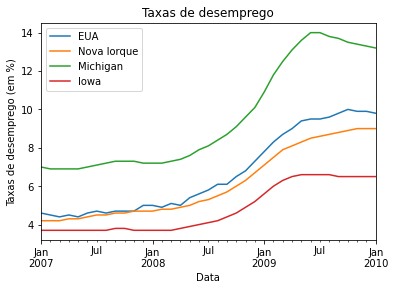

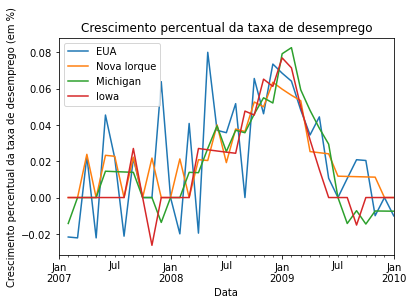

A taxa de desemprego média no período de 01-2007 a 01-2010 em/nos EUA foi de 6.65
A taxa de desemprego média no período de 01-2007 a 01-2010 em/nos Nova Iorque foi de 6.15
A taxa de desemprego média no período de 01-2007 a 01-2010 em/nos Michigan foi de 9.58
A taxa de desemprego média no período de 01-2007 a 01-2010 em/nos Iowa foi de 4.81
A taxa de desemprego máxima no período de 01-2007 a 01-2010 em/nos EUA foi de 10.0, enquanto a mínima foi de 4.4. A diferença entre os dois valores é de 5.6
A taxa de desemprego máxima no período de 01-2007 a 01-2010 em/nos Nova Iorque foi de 9.0, enquanto a mínima foi de 4.2. A diferença entre os dois valores é de 4.8
A taxa de desemprego máxima no período de 01-2007 a 01-2010 em/nos Michigan foi de 14.0, enquanto a mínima foi de 6.9. A diferença entre os dois valores é de 7.1
A taxa de desemprego máxima no período de 01-2007 a 01-2010 em/nos Iowa foi de 6.6, enquanto a mínima foi de 3.7. A diferença entre os dois valores é de 2.9


In [21]:
report(data_inicio = "01-2007", data_fim = "01-2010")

A nossa função mostra que o estado que mais sofreu com a crise de 2008 foi Michigan, pois foi o que teve o maior crescimento na sua taxa de desemprego, enquanto que Iowa teve um crescimento relativamente pequeno na sua taxa de desemprego. Desta vez, EUA e Nova Iorque tiveram novamente um comportamento similar. Finalmente, podemos usar a função para estudar o período da pandemia de covid-19:

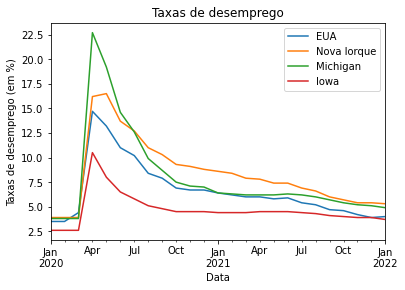

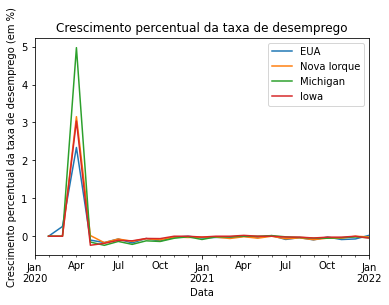

A taxa de desemprego média no período de 01-2020 a 2022-01-01 em/nos EUA foi de 6.62
A taxa de desemprego média no período de 01-2020 a 2022-01-01 em/nos Nova Iorque foi de 8.32
A taxa de desemprego média no período de 01-2020 a 2022-01-01 em/nos Michigan foi de 7.87
A taxa de desemprego média no período de 01-2020 a 2022-01-01 em/nos Iowa foi de 4.68
A taxa de desemprego máxima no período de 01-2020 a 2022-01-01 em/nos EUA foi de 14.7, enquanto a mínima foi de 3.5. A diferença entre os dois valores é de 11.2
A taxa de desemprego máxima no período de 01-2020 a 2022-01-01 em/nos Nova Iorque foi de 16.5, enquanto a mínima foi de 3.9. A diferença entre os dois valores é de 12.6
A taxa de desemprego máxima no período de 01-2020 a 2022-01-01 em/nos Michigan foi de 22.7, enquanto a mínima foi de 3.8. A diferença entre os dois valores é de 18.9
A taxa de desemprego máxima no período de 01-2020 a 2022-01-01 em/nos Iowa foi de 10.5, enquanto a mínima foi de 2.6. A diferença entre os dois valore

In [22]:
report(data_inicio = "01-2020")

Mais uma vez, vemos o quão atípico foi o choque no mercado de trabalho ocasionado pela pandemia. Uma informação interessante que podemos extrair vendo os gráficos é a de que - relativamente ao período escolhido - todas as taxas de desemprego estavam, no começo de 2020, nos seus valores mínimos e em abril de 2020 todas foram aos seus valores máximos. Como já havíamos constatado, podemos inferir que Michigan foi o estado cujo mercado de trabalho mais sofreu durante a pandemia de covid-19, enquanto o contrário vale para Iowa.

Agora que já exploramos as taxas de desemprego, vamos passar para a segunda parte do nosso projeto. Nesta parte, iremos usar técnicas de séries temporais para modelar e fazer previsões das taxas de desemprego.

## 2. Modelagem e previsão de séries temporais

Toda série temporal pode ser decomposta em três fatores: tendência, sazonalidade e resíduos. A tendência é como a série temporal se comporta "no geral" ao longo do tempo (isto é, queremos saber se a série temporal tem valores que tendem a crescer ou decrescer com o tempo, sem considerar movimentos pontuais de subida e descida); a sazonalidade são os movimentos periódicos da série temporal em um determinado intervalo de tempo (pense, por exemplo, na série temporal de temperatura em um período de 25 anos: teremos movimentos periódicos a cada 1 ano de subida e descida da temperatura em decorrência das estações do ano) e os resíduos são aquilo que não foi explicado pelos dois fatores prévios. <br />
Dito isso, vamos começar a parte de modelagem decompondo as nossas séries temporais para vermos se podemos observar coisas que nos serão úteis.

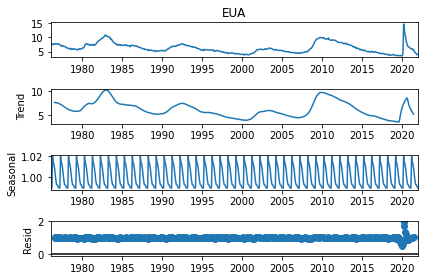

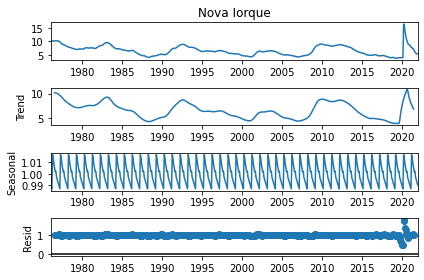

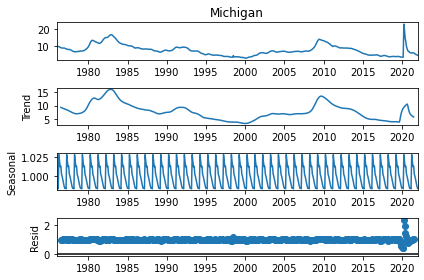

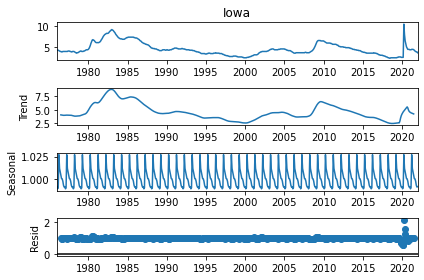

In [23]:
# Importando a ferramenta necessária
from statsmodels.tsa.seasonal import seasonal_decompose
# Decompondo todas as taxas de desemprego e plotando os resultados
for i in rates.columns:
    result = seasonal_decompose(rates[i], model = "multiplicable", period = 12)
    result.plot()

Algo interessante é notar que, para todas as taxas de desemprego, o gráfico da tendência parece-se com o próprio gráfico das taxas mas suavizado - isto ocorre pois retiramos o componente sazonal. Contudo, veja que temos tendência para todas as taxas de desemprego: isto é, as taxas de desemprego exibem tendência de variar ao longo do tempo. Também, exibem sazonalidade - mas note que o componente sazonal não parece ser responsável por variações de maiores magnitudes (veja a escala dos gráficos). Por último, o componente residual é constante ao longo do tempo, menos em 2020 - isso faz muito sentido, visto que o choque nas taxas de desemprego durante a pandemia de covid-19 não pode ser explicada pela sua tendência (já que as taxas de desemprego estavam em tendência descendente no começo de 2020) e muito menos pelo componente sazonal, já que este só é responsável por variações de pequena magnitude.

Um dos conceitos centrais para podermos fazer o tipo de modelagem que queremos é a _estacionariedade_. Uma série temporal é estacionária quando suas características estatísticas não mudam ao longo do tempo - isto é, temos média, covariância, entre outras medidas constantes ao longo do tempo. Isto também quer dizer que a série temporal não tem tendência e nem sazonalidade. O conceito puro de estacionariedade pode ser muito irrealista às vezes, e isto se deve ao fato de que teoricamente essas são as condições necessárias; contudo, na vida real, dificilmente uma série temporal terá suas características estatísticas exatamente constantes ao longo do tempo. E é aí que entra o teste ADF, ou Augmented Dickey-Fuller Test. O teste ADF serve para testarmos a hipótese de que uma série temporal é estacionária ou não (mais precisamente, se ela é estacionária em relação à tendência ou não). Por ser um teste de hipótese, o ADF retornar-nos-á um valor-p - caso este valor-p seja menor do que 5%, podemos rejeitar a hipótese de que a série temporal não é estacionária: caso contrário, a série temporal não será estacionária. <br />
A implementação do teste ADF em Python é feita, geralmente, pelo statsmodels - e o teste irá nos retornar várias medidas, mas iremos nos focar em apenas duas duas: o score e o valor-p. O valor-p é aquilo que já dissemos, um teste para saber se a série temporal é estacionária em relação à tendência. Já o score é uma "medida" da chance de a série temporal ser estacionária. Basicamente, o quão mais negativo for o score, mais chances da série temporal ser estacionária.

In [24]:
# Importando a ferramenta necessária
from statsmodels.tsa.stattools import adfuller
# Calculando e printando o score e o p-valor para todas as taxas de desemprego
for i in rates.columns:
    print("")
    print(f"score para {i}: {adfuller(rates[i])[0]}")
    print(f"p-value para {i}: {adfuller(rates[i])[1]}")


score para EUA: -3.200715935200877
p-value para EUA: 0.01994327546144729

score para Nova Iorque: -3.8842880755339855
p-value para Nova Iorque: 0.0021535696881444513

score para Michigan: -2.9819422716878066
p-value para Michigan: 0.03661552418925582

score para Iowa: -2.33970337310723
p-value para Iowa: 0.15948229393041236


Exceto Iowa, todas as taxas de desemprego nos deram valores-p abaixo de 5%. Isto significa que apenas Iowa tem uma série temporal de desemprego não-estacionária em relação à tendência. Porém, a história não acaba aí. Como queremos estacionariedade para nossos modelos, podemos "forçar" a série temporal a ser estacionária. Um dos métodos mais usados é tomar a primeira diferença da série temporal com ela mesma (isto é, subtrair de cada valor no período $t$ o valor no período $t - 1$). Vamos checar se isto vai funcionar:

In [25]:
# Tomando a primeira diferença 
iowa_1diff = rates["Iowa"].diff().dropna()
# Fazendo o teste ADF para a série temporal da taxa de desemprego de Iowa após tomada a primeira diferença
print(adfuller(iowa_1diff)[0:2])

(-19.38860468772709, 0.0)


Após tomarmos a primeira diferença, vemos que a série temporal se tornou estacionária em relação à tendência, e seu score ficou ainda melhor. Isto significa que podemos tomar a primeira diferença para esta taxa de desemprego para modelarmos. 

Agora, podemos passar para a modelagem. Antes disso, precisaremos explicar o modelo que usaremos, que será um modelo ARIMA. Para isto, precisaremos primeiro explicar o que são modelos ARMA (AR e MA) para entendermos modelos ARIMA. <br />
* Modelos  AR <br />
Um modelo AR, ou modelo auto-regressivo, é um modelo que usa os próprios valores de uma série temporal para saber o que ocorrerá com ela num dado momento $t$. Um modelo AR possui apenas um parâmetro, que chamamos de $p$. A forma geral de um modelo $AR(p)$ é:
$$AR(p): y_t = \alpha_0 + \alpha_1y_{t-1} + \alpha_2y_{t-2} + ... + \alpha_py_{t-p} + \epsilon_t$$
onde $\alpha_0$ é uma constante, $\alpha_1$$,$ $...$$,$ $\alpha_p$ são parâmetros diferentes de 0 e $\epsilon_t$ é um termo de erro, que consideramos que forme uma série temporal $\{\epsilon_t\}$ de média 0 e variância finita.
* Modelos MA <br />
Um modelo MA (ou modelo de médias móveis) é um modelo que, ao invés do modelo AR que usa os valores prévios da série temporal para determinar o que ocorre no período $t$, usa os termos de erro prévios para determinar o que ocorre no período $t$. No caso, usa-se os $q$ termos de erro prévios, então um modelo MA possui apenas um parâmetro, que chamamos de $q$. A forma geral de um modelo $MA(q)$ é:
$$MA(q): y_t = \theta_0 + \epsilon_t + \theta_1\epsilon_{t-1} + \theta_2\epsilon_{t-2} + ... + \theta_q\epsilon_{t-q}$$
onde $\theta_0$ é uma constante, $\theta_1$$,$ $...$$,$ $\theta_q$ são parâmetros diferentes de 0 e $\epsilon_{t-q}$$,$ $\epsilon_{t + 1 -q}$$,$ $...$$,$ $\epsilon_t$ são os termos de erro nos períodos $t - q$$,$ $(t + 1) - q$$,$ $...$$,$ $t$.
* Modelos ARMA <br />
Um modelo ARMA, ou modelo auto-regressivo de médias móveis, é simplesmente uma combinação dos modelos AR e MA. Sendo assim, um modelo ARMA terá dois parâmetros: $p$ e $q$, e $p$ será o parâmetro da parte AR do modelo, enquanto $q$ será o da parte MA do modelo. A forma geral de um modelo $ARMA(p,q)$ é:
$$ARMA(p,q): y_t = c + \alpha_1y_{t-1} + \alpha_2y_{t-2} + ... + \alpha_py_{t-p} + \theta_1\epsilon_{t-1} + \theta_2\epsilon_{t-2} + ... + \theta_q\epsilon_{t-q} + \epsilon_t $$
onde $c$ é uma constante, e o resto é como já foi definido previamente. <br />
* Modelos ARIMA <br />
Um modelo ARIMA, ou modelo auto-regressivo integrado de médias móveis, é um modelo ARMA que incorpora o passo de diferenciação na série temporal. Isto é, lembre-se que tomamos a primeira diferença para tornar a série de Iowa estacionária - em um modelo ARIMA, nós não precisaríamos fazer isso antes de encaixar a série temporal no modelo: pois este passo de diferenciação já estaria embutido no próprio modelo. Sendo assim, para séries temporais que não são estacionárias, modelos ARIMA são muito valiosos, pois não precisamos tornar a série temporal estacionária para usarmos estes modelos: eles próprios já a deixam estacionária ao fazer a diferenciação. Tirando a parte da diferenciação, o modelo ARIMA segue como um modelo ARMA normal. Um modelo ARIMA incorpora além dos parâmetros $p$ e $q$ dos modelos $ARMA(p,q)$, um parâmetro $d$, que é a ordem de diferenciação. Pense no que fizemos para tornar a série de Iowa estacionária: chame-a de $I_t$: o que fizemos foi tomar a primeira diferença, isto é, calculamos $I_t$ $-$ $I_{t-1}$. Quando tomamos a diferença na ordem $d$ para a série temporal $Y_t$, fazemos $Y_t$ $-$ $Y_{t-d}$. A forma geral de um modelo $ARIMA(p,d,q)$ é: <br />
$$ARIMA(p,d,q): y'_t = c + \alpha_1y'_{t-1} + \alpha_2y'_{t-2} + ... + \alpha_py'_{t-p} + \theta_1\epsilon_{t-1} + \theta_2\epsilon_{t-2} + ... + \theta_q\epsilon_{t-q} + \epsilon_t$$
onde $y'_t$ $=$ $y_t$ $-$ $y_{t-d}$, e o resto é como foi definido previamente

Agora que já sabemos quais vão ser os modelos que usaremos, vamos implementar uma ferramenta que encontra o melhor modelo ARIMA para nossas séries temporais dadas. <br />

In [26]:
import pmdarima as pm
for i in rates.columns:
    print(f"\n {i}")
    results = pm.auto_arima(rates[i], max_p = 10, max_q = 10, max_order = None)
    print(results.summary())


 EUA
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  553
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -395.040
Date:                Sun, 29 May 2022   AIC                            792.081
Time:                        14:02:24   BIC                            796.394
Sample:                             0   HQIC                           793.766
                                - 553                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.2450      0.001    216.622      0.000       0.243       0.247
Ljung-Box (L1) (Q):                   0.45   Jarque-Bera (JB):           2668326.67
Prob(Q):                              0.5

Para a taxa de desemprego dos Estados Unidos, obtemos um modelo ARIMA(0,1,0). Isto significa um modelo do tipo:
$$ARIMA(0,1,0): y'_t = \epsilon_t$$ <br />
Note que como temos d = 1, $y'_t$ $=$ $y_t$ $-$ $y_{t-1}$. Substituindo na equação acima, $y_t$ $-$ $y_{t-1}$ $=$ $\epsilon_t$. Daí, $y_t$ = $y_{t-1}$ + $\epsilon_t$. Este modelo nos sugere que a taxa de desemprego nos EUA no período t é melhor modelada por uma equação que diz-nos que a taxa de desemprego dos EUA no período $t$ é apenas a taxa no período $t$ $-$ $1$ acrescida de um termo de erro $\epsilon_t$ aleatório. Este modelo é muito conhecido, e é chamado de *passeio aleatório*. Passeios aleatórios aparecem em vários outros contextos, tais como: finanças, física, etc.. Note que $y_t$ $=$ $y_{t-1}$ $+$ $\epsilon_t$ implica que a melhor previsão (ou melhor chute) para o valor de $y_t$ é simplesmente $y_{t-1}$, pois como dissemos, a média dos termos de erro é igual a 0 - isto é, seu valor esperado $\mathbb{E}[\epsilon_t]$ é igual a 0. <br /> <br />
Para a taxa de desemprego de Nova Iorque, obtemos um modelo ARIMA(0,1,2). Isto significa um modelo do tipo:
$$ARIMA(0,1,2): y'_t = \theta_1\epsilon_{t-1} + \theta_2\epsilon_{t-2} + \epsilon_t$$ ou $$y_t = y_{t-1} + \theta_1\epsilon_{t-1} \theta_2\epsilon_{t-2} + \epsilon_t$$
Este modelo também é bem conhecido, e ele se chama "Damped Holt's model". Este modelo é usado para séries temporais que possuem alguma tendência, e o "Damped" significa que os valores preditos dão-nos uma curva mais "plana". <br/> <br/> 
Para a taxa de desemprego de Michigan, obtemos um modelo ARIMA(1,1,2). Isto significa um modelo do tipo: 
$$ARIMA(1,1,2): y'_t = \alpha_1y'_{t-1} + \theta_1\epsilon_{t-1} + \theta_2\epsilon_{t-2}$$ <br />
Para a taxa de desemprego de Iowa, obtemos um modelo ARIMA(1,1,1). Isto significa um modelo do tipo:
$$ARIMA(1,1,1): y'_t = \alpha_1y'_{t-1} + \theta_1\epsilon_{t-1}$$

Agora, vamos escolher dois modelos para fazer uma predição. Veja que quando criamos os modelos, temos vários valores ali com várias siglas. Duas vão nos importar: a sigla "AIC" e a "BIC". AIC (Akaike Information Criteria) e BIC (Bayesian Information Criteria) são duas métricas de avaliação de modelos de séries temporais. Basicamente, quão maior eles forem, melhor adequados serão os modelos. Os dois critérios nem sempre nos dão valores iguais (isto se deve ao fato de que o AIC penaliza mais a complexidade do modelo). <br />
Os modelos que tiveram melhor AIC e BIC foram os modelos de Nova Iorque e Michigan. Então, vamos começar o processo de criar uma predição.

Para começarmos a criar as nossas predições, vamos criar "objetos" que serão os modelos ARIMA selecionados pelos critérios AIC e BIC. Após isso, vamos adequar os nossos modelos (isto é, "fitar") às séries temporais em questão. Ao "fitar" os modelos, vamos encontrar os parâmetros adequados para cada série temporal.

In [27]:
# Importando a ferramenta necessária
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Criando os objetos que serão os modelos
modelo_NovaIorque = SARIMAX(rates["Nova Iorque"], order = (0,1,2))
modelo_Michigan = SARIMAX(rates["Michigan"], order = (1,1,2))
# "Fitando" os modelos
result_NovaIorque = modelo_NovaIorque.fit()
result_Michigan = modelo_Michigan.fit()

Agora, podemos criar as nossas predições. O período escolhido para ser previsto é o período dos últimos 10 meses que temos na amostra. Isto é, vamos - a partir do nosso modelo - prever quais serão as taxas de desemprego de abril de 2021 a janeiro de 2022. Como estas são datas para as quais nós já temos os valores reais, isto vai nos permitir comparar os resultados dos modelos com o que aconteceu na realidade. 

In [28]:
# Criando as predições
predição_NovaIorque = result_NovaIorque.get_prediction(start = -10)
predição_Michigan = result_Michigan.get_prediction(start = -10)

Vamos extrair os valores preditos para as duas predições.

In [29]:
# Extraindo os valores preditos
media_predição_NY = predição_NovaIorque.predicted_mean
media_predição_Michigan = predição_Michigan.predicted_mean

Agora que já temos os valores preditos, vamos plotar um gráfico que tenha todos os valores reais e preditos.

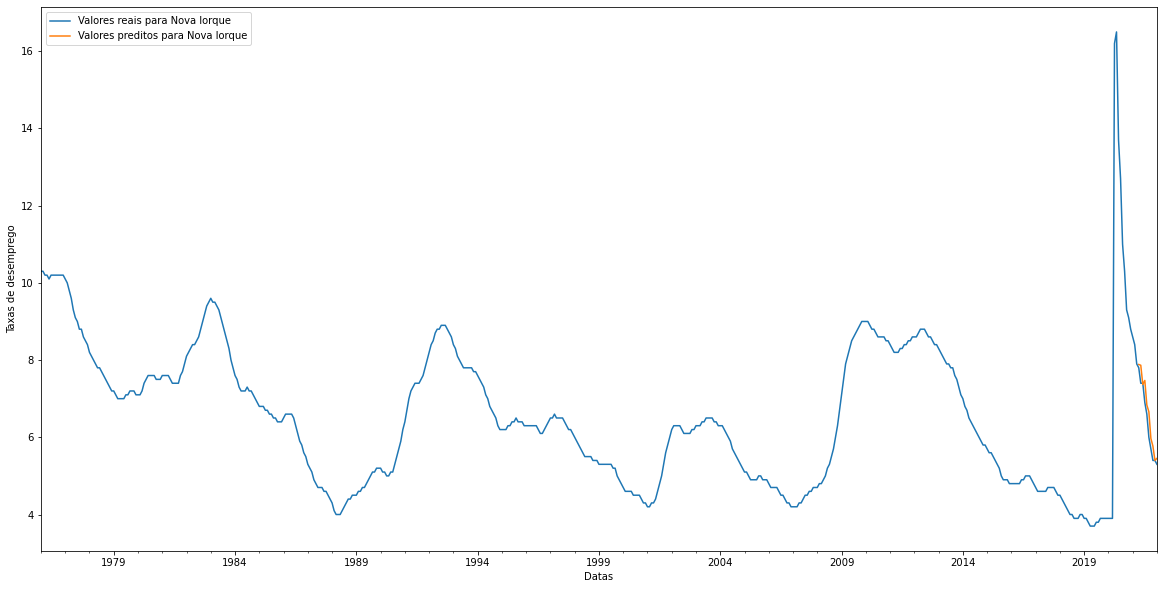

In [30]:
# Plotando as taxas reais e preditas com as devidas legendas
rates["Nova Iorque"].plot(label = "Valores reais para Nova Iorque", figsize = (20,10))
media_predição_NY.plot(label = "Valores preditos para Nova Iorque", figsize = (20,10))
plt.legend()
# Adicionando legendas aos eixos
plt.xlabel("Datas")
plt.ylabel("Taxas de desemprego")
# Mostando o gráfico
plt.show()

Olhando o gráfico nesta escala, parece que os valores preditos para a taxa de desemprego de Nova Iorque estão muito próximos dos valores reais. Contudo, esta avaliação não é suficiente: para termos uma análise relativamente boa da efetividade da nossa predição, precisamos saber se os "erros" da nossa predição são "toleráveis". Para isso, vamos calcular o intervalo de confiança da nossa predição (ou banda de confiança, pela sua visualização gráfica) - que nada mais é do que uma margem de erro. Caso os valores reais estejam dentro da nossa banda de confiança, isto será um bom sinal para nossa predição - indicando que ela não errou muito.

In [31]:
# Calculando os intervalos de confiança
inter_conf_NY = predição_NovaIorque.conf_int()
inter_conf_MI = predição_Michigan.conf_int()

Vamos ver o que é o intervalo de confiança:

In [32]:
inter_conf_NY

,lower Nova Iorque,upper Nova Iorque
DATE,,
2021-04-01,6.805748,8.967193
2021-05-01,6.784640,8.946085
2021-06-01,6.285370,8.446815
2021-07-01,6.391348,8.552793
2021-08-01,5.756906,7.918351
2021-09-01,5.579864,7.741309
2021-10-01,4.888098,7.049543
2021-11-01,4.689798,6.851243
2021-12-01,4.321789,6.483234


Agora, vamos plotar um gráfico que compare os valores reais e preditos para Nova Iorque, e que leve em conta a banda de confiança. A área sombreada em rosa representará a banda de confiança. Caso os valores reais estejam dentro dela, nossa predição passou em um primeiro "teste de qualidade".

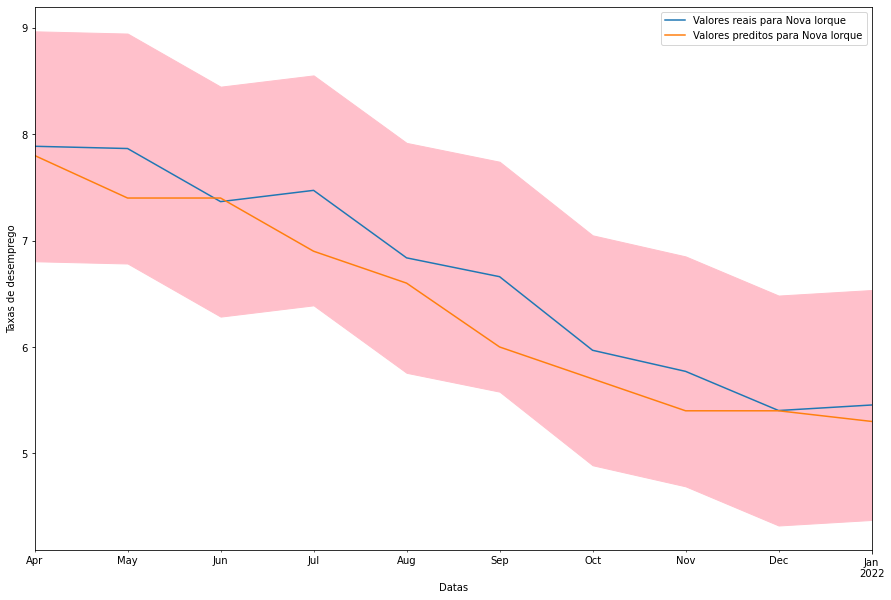

In [33]:
# Plotando as taxas reais e preditas com as devidas legendas
media_predição_NY.plot(label = "Valores reais para Nova Iorque", figsize = (15,10))
rates["Nova Iorque"][-10:].plot(label = "Valores preditos para Nova Iorque", figsize = (15,10))
plt.legend()
# Adicionando legendas aos eixos
plt.xlabel("Datas")
plt.ylabel("Taxas de desemprego")
# Plotando o intervalo de confiança
plt.fill_between(media_predição_NY.index, inter_conf_NY["lower Nova Iorque"], inter_conf_NY["upper Nova Iorque"], color = "pink")
# Mostrando o gráfico
plt.show()

Os valores reais estão dentro da banda de confiança! Não apenas isso, como nossa predição praticamente acertou de forma exata as taxas de desemprego nos mês de dezembro. Agora, vamos replicar o que fizemos para nossa predição das taxas de desemprego de Michigan:

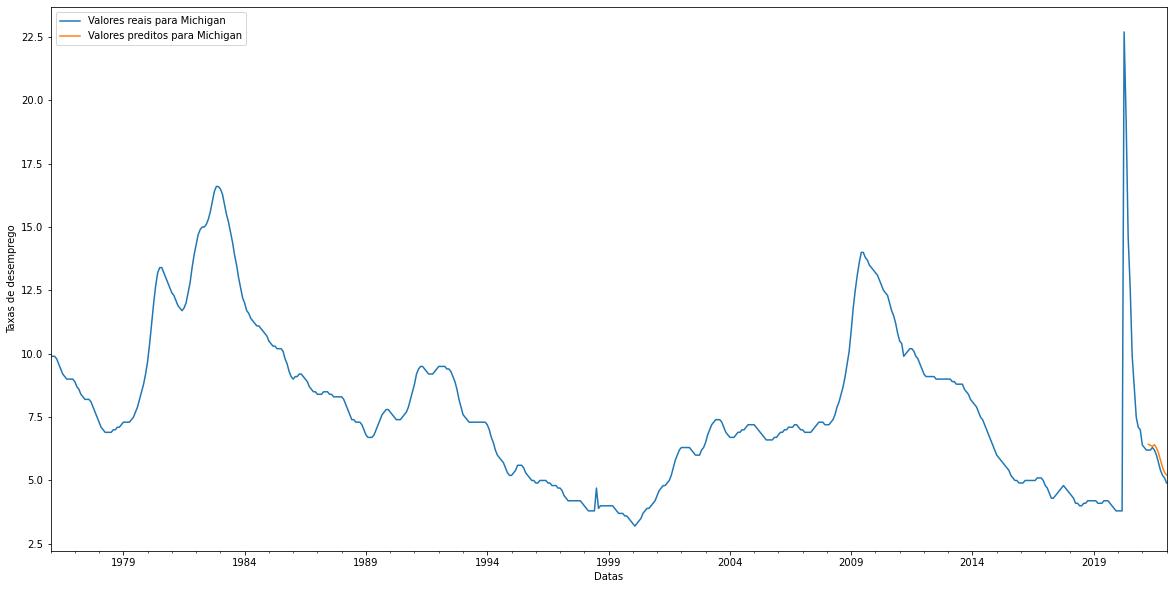

In [34]:
# Plotando as taxas reais e preditas com as devidas legendas
rates["Michigan"].plot(label = "Valores reais para Michigan", figsize = (20,10))
media_predição_Michigan.plot(label = "Valores preditos para Michigan", figsize = (20,10))
plt.legend()
# Adicionando legendas aos eixos
plt.xlabel("Datas")
plt.ylabel("Taxas de desemprego")
# Mostrando o gráfico
plt.show()

Também, como vimos para Nova Iorque, as taxas reais e preditas parecem estar muito próximas. Vamos replicar o plot que mostra a banda de confiança como uma área sombreada:

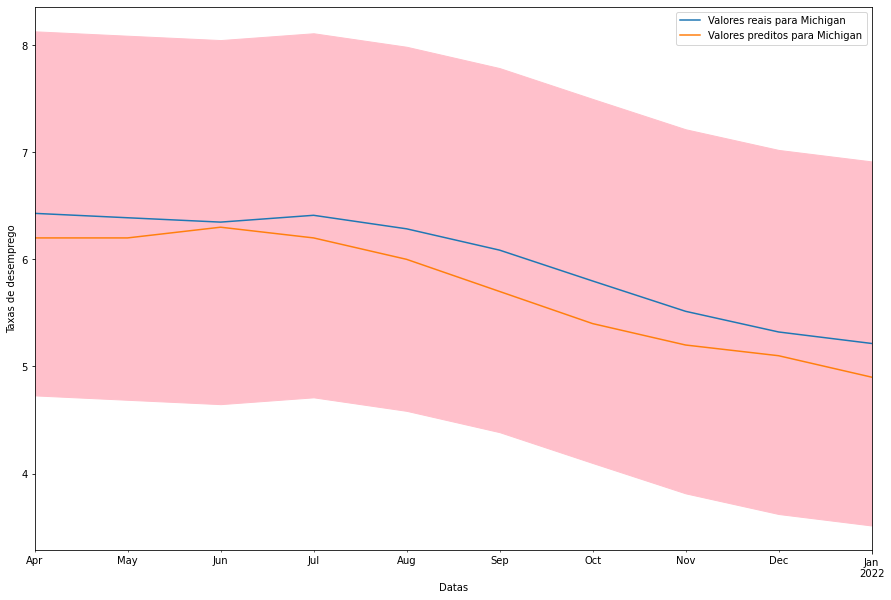

In [35]:
# Plotando as taxas reais e preditas com as devidas legendas
media_predição_Michigan.plot(label = "Valores reais para Michigan", figsize = (15,10))
rates["Michigan"][-10:].plot(label = "Valores preditos para Michigan", figsize = (15,10))
plt.legend()
# Adicionando legendas aos eixos
plt.xlabel("Datas")
plt.ylabel("Taxas de desemprego")
# Plotando o intervalo de confiança
plt.fill_between(media_predição_Michigan.index, inter_conf_MI["lower Michigan"], inter_conf_MI["upper Michigan"], color = "pink")
# Mostrando o gráfico
plt.show()

Vemos que tanto para Michigan quanto para Nova Iorque os valores reais estão dentro dos intervalos de confiança. Contudo, notamos que os valores preditos para Michigan parecem estar mais perto dos valores reais para Michigan do que os valores preditos para Nova Iorque estão em relação aos valores reais de Nova Iorque. Nosso próximo (e último) passo será "medir" o quão próximas estão as previsões. Para isso, tomaremos uma métrica muito simples, chamada *MSE* (ou mean squared errors). O MSE, caso você não esteja familiarizado, faz a média da distância dos valores preditos em relação aos reais ao quadrado. A fórmula é dada por: $\dfrac{\sum_{t = 1}^{n} (\hat{y}_t - y_t)^2}{n}$, onde $\hat{y}_t$ são os valores preditos no período $t$ e $y_t$ são os valores reais no período $t$. A fórmula considera $n$ períodos. Então, vamos calcular o MSE para as duas predições:

In [36]:
# Importando a ferramenta necessária
from sklearn.metrics import mean_squared_error
# Calculando o MSE para as duas predições
print("MSE para Michigan:", round(mean_squared_error(rates["Michigan"][-10:], media_predição_Michigan), 3))
print("MSE para Nova Iorque:", round(mean_squared_error(rates["Nova Iorque"][-10:], media_predição_NY), 3))

MSE para Michigan: 0.077
MSE para Nova Iorque: 0.128


Nossa intuição foi confirmada, e a predição para Michigan performou melhor!

## Conclusão

Nosso projeto foi dividido em duas partes: análise e modelagem de séries temporais. Na análise, percebemos que diferentes estados têm padrões diferentes na evolução das taxas de desemprego, assim como percebemos que diferentes estados reagem de forma diferente a choques no mercado de trabalho - uma das razões é a própria composição do setor produtivo em diferentes estados. <br />
Na parte de modelagem, usamos alguns modelos ARIMA para descrever a evolução das taxas de desemprego, e ainda conseguimos fazer duas predições que performaram relativamente bem para as taxas de desemprego de Michigan e de Nova Iorque.